# Titulo

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/Colab Notebooks/TCC/"

except:
    path = "output/"

Mounted at /content/drive


In [2]:
## Imports
import pickle as pk
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from IPython.display import clear_output
import sklearn.neural_network as sknn

# Leitura e exploração dos dados

There are 39.92506244796004% of nominal cases


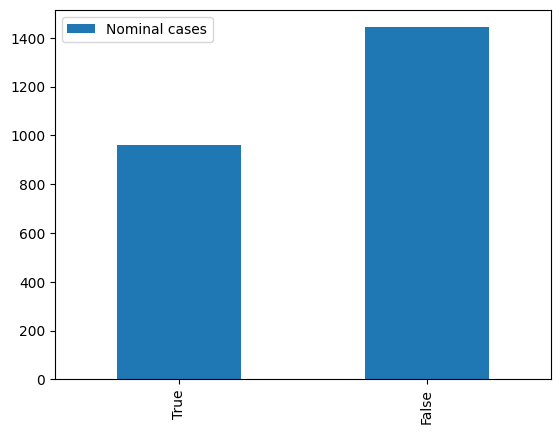

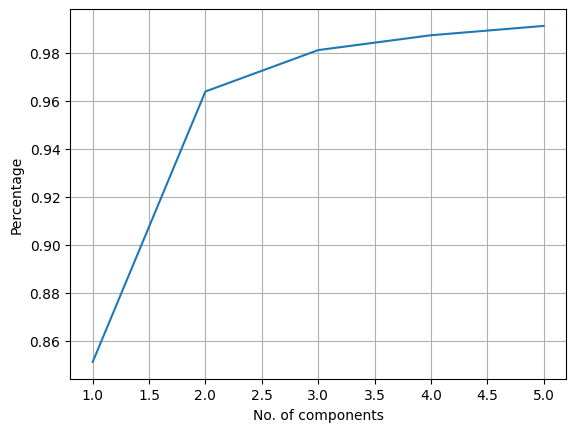

In [3]:
### Extraindo os dados
with open(path+"Tsdata.pickle", "rb") as fname:
    ([Xts]) = pk.load(fname)

with open(path+"alldata_info.pickle", "rb") as fname:
    (df2save) = pk.load(fname)

df2save['target'] = (df2save['case'] == 'A') | (df2save['case'] == 'B') | (df2save['case'] == 'C') | (df2save['case'] == 'R')
df2save['target'].value_counts().sort_values().plot(kind='bar')
plt.legend({'Nominal cases'})

print('There are ' + str(df2save['target'].sum()/len(df2save['target'])*100) + '% of nominal cases')

y = 1 - df2save['target']

### PCA + Graficos
pctExplVar = 0.99
pca = PCA(n_components=pctExplVar)
Xtsred = pca.fit_transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()

In [4]:
Xts.shape, Xtsred.shape

((2402, 48), (2402, 5))

In [5]:
Xtsred[0:5,:]

array([[-5.53551908,  1.17782852,  0.2242756 , -0.15904104, -0.24356281],
       [-5.68152683,  1.0116827 ,  0.15158924, -0.10148506, -0.08661173],
       [-5.64041655,  0.8850916 ,  0.1326918 ,  0.03178893,  0.11990451],
       [-5.74539635,  1.20623889,  0.24005609, -0.17148133, -0.23251438],
       [-5.68920261,  1.07014931,  0.13065075, -0.13051693, -0.0616693 ]])

Plotando os reusltados do PCA nos gráficos abaixo podemos observar claramente que temos alguns outliers nos dados.

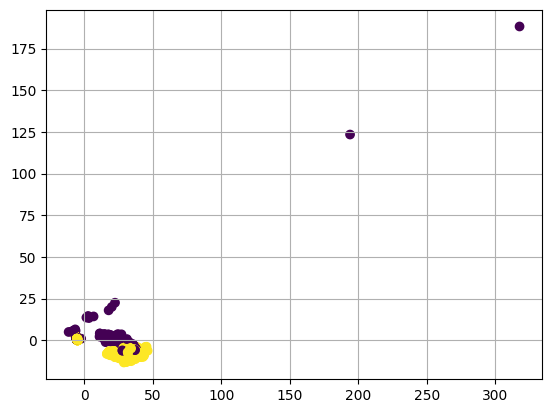

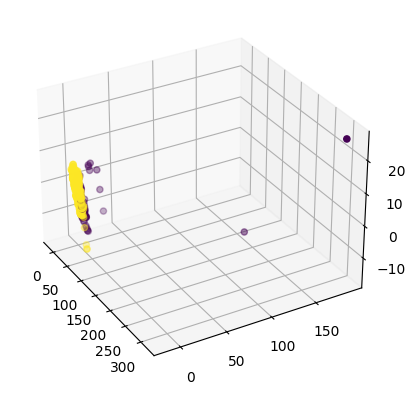

In [6]:
# Gráficos 2/3D - Resultado do PCA
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[:,0],Xtsred[:,1],c = y)
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[:,0],Xtsred[:,1],Xtsred[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


A função abaixo foi utlizada para filtrar outliers nos dados.

In [7]:
# Função para filtrar outliers
def reject_outliers(data, m = 4.):
    data = data[:,0]
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev.all() else np.zeros(len(d))
    return s<m

map = reject_outliers(Xtsred)

Nos gráficos abaixo, podemos observar que os outliers possuem uma fração maior de casos com presença de dano quando comparado aos não outliers, mas ainda possuem uma quantidade significativa de casos nominais

383 2019 2402


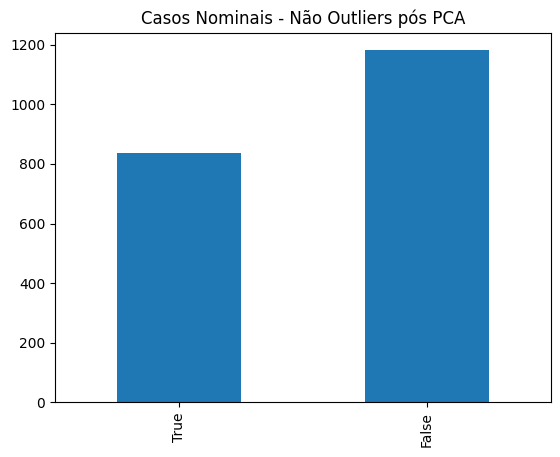

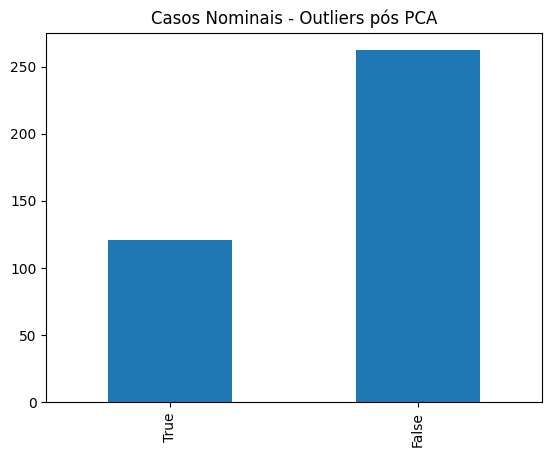

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# Graifco - Não Dano x Dano nos outliers e não outliers
print(np.sum(np.invert(map)),np.sum(map),len(map))
df2save['target'].loc[map].value_counts().sort_values().plot(kind='bar')

plt.title("Casos Nominais - Não Outliers pós PCA")
plt.show()
plt.figure()

df2save['target'].loc[np.invert(map)].value_counts().sort_values().plot(kind='bar')
plt.title("Casos Nominais - Outliers pós PCA")
plt.show()
plt.figure()

Realizamos novamente os gráficos para autocorrelação ddos componentes principais, dessa vez filtrando os outliers. A função de filtragem parece ter sido adequada.

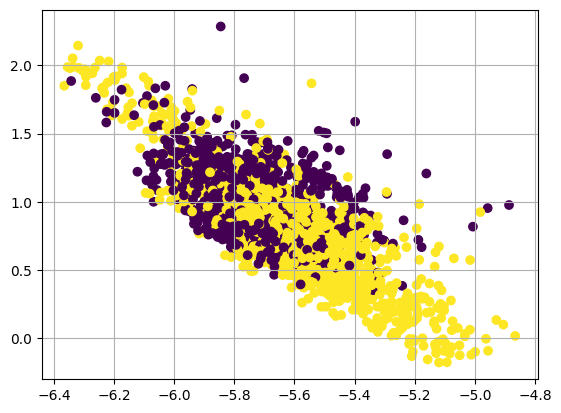

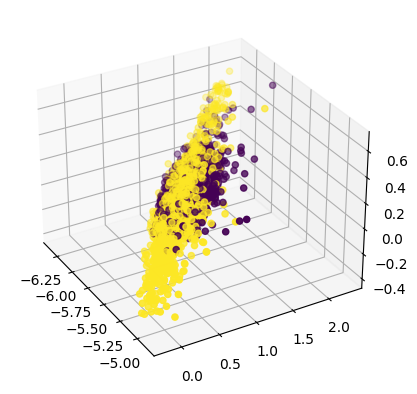

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred[map,0],Xtsred[map,1],c = y[map])
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()


Hipotese alternativa: Realizar a filtragem de outliers antes do PCA.

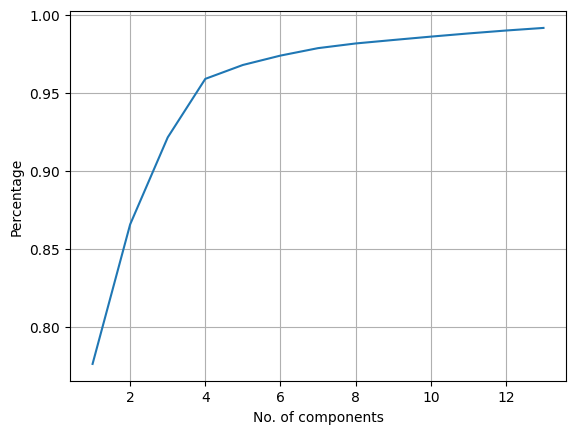

2402
2012 None


In [10]:
# Filtragem + PCA
pctExplVar = 0.99
pca2 = PCA(n_components=pctExplVar)

#Realizamos o fit no conjunto filtrado, mas mantemos o conjunto inteiro após a transformada
map_xts = reject_outliers(Xts)
pca2.fit(Xts[map_xts])
Xtsred_filtered = pca2.transform(Xts)

plt.figure()
plt.plot(np.arange(len(np.cumsum(pca2.explained_variance_ratio_)))+1,np.cumsum(pca2.explained_variance_ratio_))
plt.grid()
plt.ylabel('Percentage')
plt.xlabel('No. of components')
plt.show()
print(sum(map_xts),print(len(Xts)))

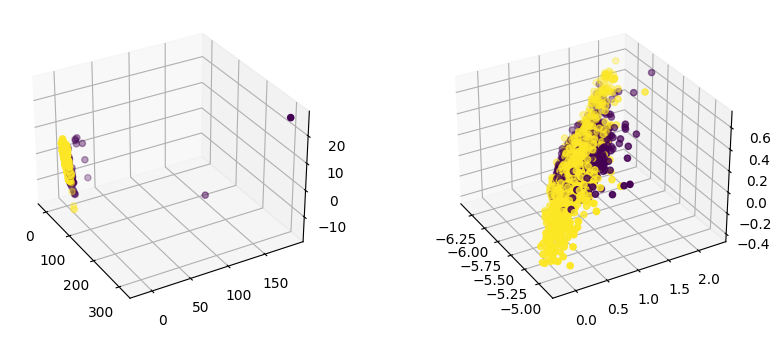

In [11]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(Xtsred[:,0],Xtsred[:,1],Xtsred[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(Xtsred[map,0],Xtsred[map,1],Xtsred[map,2],c = y[map])
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)

plt.show()

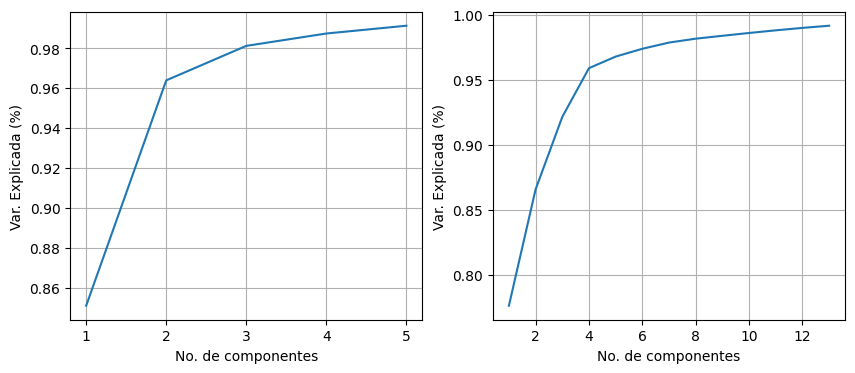

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

ax1.plot(np.arange(len(np.cumsum(pca.explained_variance_ratio_)))+1,np.cumsum(pca.explained_variance_ratio_))
ax1.grid()
ax1.set_ylabel('Var. Explicada (%)')
ax1.set_xlabel('No. de componentes')

ax2.plot(np.arange(len(np.cumsum(pca2.explained_variance_ratio_)))+1,np.cumsum(pca2.explained_variance_ratio_))
ax2.grid(2)

ax2.set_ylabel('Var. Explicada (%)')
ax2.set_xlabel('No. de componentes')
plt.show()


Observamos que ao remover os outliers antes de realizar o PCA, o numero de componentes necessários para atingir 99% de variancia explicada sobe drasticamente, de 5 para 13.

Abaixo, plotamos o grafico de autocorrelação para os componentes principais do novo PCA obtido. Observe que os outliers foram mantidos apos a transformada, tendo sido apenas desconsiderados para montar a matriz do PCA.

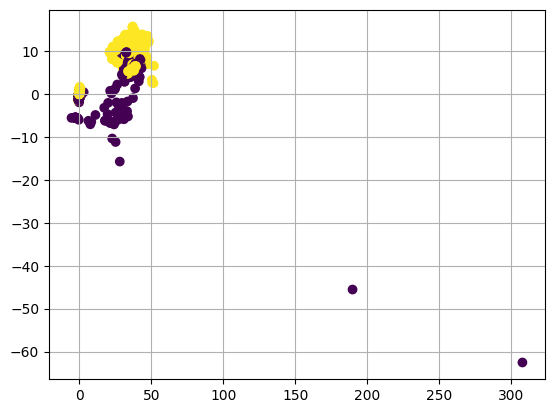

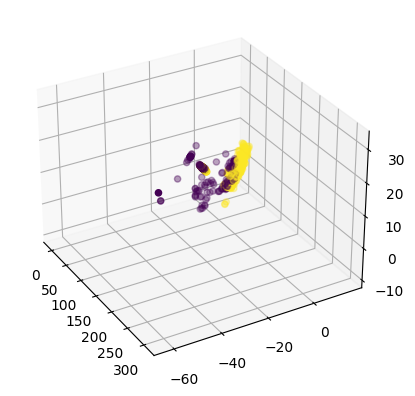

In [13]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],c = y)
ax.grid()
plt.show()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xtsred_filtered[:,0],Xtsred_filtered[:,1],Xtsred_filtered[:,2],c = y)
ax.grid()

#Default = 30 -60 0
ax.view_init(30, -30, 0)
plt.show()

# Parameter search:

In [14]:
keys = []
param_grids = {}
# Define models
models = {}

# ------------------------------------------------------
keys.append("DTC")
param_grids[keys[-1]] = {
            "criterion":["gini","entropy","log_loss"],
            "max_depth":sp_randInt(5,20),
            "max_leaf_nodes":sp_randInt(50,200),
            #"max_features" :[None],
            #"splitter":["best"]
            }


models[keys[-1]] = DecisionTreeClassifier
# ------------------------------------------------------
keys.append("RDG")
param_grids[keys[-1]] ={
            "alpha": sp_randFloat(0,2),
            "class_weight":["balanced",None],
            "solver":["svd","cholesky","lsqr","sparse_cg"]
            }
models[keys[-1]] = RidgeClassifier
# ------------------------------------------------------
keys.append("SVC")
param_grids[keys[-1]] ={
            "kernel":['linear','poly', 'rbf', 'sigmoid'],
            "gamma":["auto","scale"],
            "coef0":sp_randFloat(-1,1),
            "degree":sp_randInt(2,5)
            }
models[keys[-1]] = SVC



In [15]:
datasets = []

datasets.append((Xts,y,"Sem PCA"))
datasets.append((Xtsred,y,"PCA Smples"))
datasets.append((Xtsred[map,:],y[map],"PCA+Filtro"))
datasets.append((Xtsred_filtered,y,"Filtro+PCA"))

In [16]:
metricas = []

metricas.append(("BA",metrics.balanced_accuracy_score))
metricas.append(("F1",metrics.f1_score))
metricas.append(("RE",metrics.recall_score))

In [59]:
def describe_dict(d):
    # Esta função recebe um dicionário como entrada e retorna uma string
    # contendo os itens do dicionário formatados como pares chave-valor.

    # Por exemplo, se o dicionário for: {'alpha': 0.01, 'solver': 'auto'}
    # a função retornará: 'alpha=0.01, solver=auto'

    return ", ".join([f"{key}={value}" for key, value in d.items()])

In [70]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
base_results = {}
search_results = {}

nIter = 5
nSearch = 1


PredDF = pd.DataFrame()
ModelsDF = pd.DataFrame()
for (k,dados) in enumerate(datasets):
    X = StandardScaler().fit_transform(X=dados[0])
    for (j,key) in enumerate(keys):
        print(key,dados[-1])
        for i in range(nIter):
            #print(i,"th iteration")

            X_train, X_test, y_train, y_test = train_test_split(X, dados[1],test_size=0.4,random_state=i)

            modelo = models[key]()
            modelo.fit(X_train,y_train)
            y_pred = modelo.predict(X_test)

            modelo = models[key]()
            random_search = RandomizedSearchCV(modelo, param_grids[key], random_state=i,
                                            n_iter = nSearch, verbose = 0, cv = rkf, refit = "f1",
                                            scoring = ["balanced_accuracy","recall","f1"])

            random_search.fit(X_train, y_train)
            y_srch = random_search.predict(X_test)


            # Predictions to PredDF
            PredDF = pd.concat([PredDF,pd.DataFrame({
                    "y_test":y_test,
                    "y_pred":y_pred,
                    "y_srch":y_srch,
                })], axis=0, ignore_index=True)

            # Model information to ModelsDF
            ModelsDF = pd.concat([ModelsDF,pd.DataFrame({
                    "model":key,
                    "features":dados[-1],
                    "niter":i,
                    "best_model_description": describe_dict(random_search.best_params_),
                    "BA base":metricas[0][1](y_test, y_pred),
                    "F1 base":metricas[1][1](y_test, y_pred),
                    "RE base":metricas[2][1](y_test, y_pred),
                    "BA srch":metricas[0][1](y_test, y_srch),
                    "F1 srch":metricas[1][1](y_test, y_srch),
                    "RE srch":metricas[2][1](y_test, y_srch)
                    },
                index=[0])], axis=0, ignore_index=True)


DTC Sem PCA
RDG Sem PCA
SVC Sem PCA
DTC PCA Smples
RDG PCA Smples
SVC PCA Smples
DTC PCA+Filtro
RDG PCA+Filtro
SVC PCA+Filtro
DTC Filtro+PCA
RDG Filtro+PCA
SVC Filtro+PCA


In [71]:
ModelsDF

,model,features,niter,best_model_description,BA base,F1 base,RE base,BA srch,F1 srch,RE srch
0,DTC,Sem PCA,0,"criterion=gini, max_depth=10, max_leaf_nodes=117",0.954968,0.962700,0.962700,0.946759,0.955516,0.953819
1,DTC,Sem PCA,1,"criterion=entropy, max_depth=16, max_leaf_node...",0.945601,0.957940,0.962069,0.952498,0.965047,0.975862
2,DTC,Sem PCA,2,"criterion=gini, max_depth=18, max_leaf_nodes=122",0.949302,0.958517,0.959364,0.949302,0.958517,0.959364
3,DTC,Sem PCA,3,"criterion=log_loss, max_depth=13, max_leaf_nod...",0.966608,0.972125,0.967071,0.957485,0.968240,0.977470
4,DTC,Sem PCA,4,"criterion=log_loss, max_depth=19, max_leaf_nod...",0.951174,0.961373,0.960549,0.951494,0.963342,0.969125
5,RDG,Sem PCA,0,"alpha=1.0976270078546495, class_weight=None, s...",0.914486,0.939677,0.982238,0.914486,0.939677,0.982238
6,RDG,Sem PCA,1,"alpha=0.834044009405148, class_weight=balanced...",0.908702,0.939819,0.982759,0.937316,0.952055,0.958621
7,RDG,Sem PCA,2,"alpha=0.8719898042840075, class_weight=None, s...",0.916746,0.940375,0.975265,0.918012,0.941176,0.975265
8,RDG,Sem PCA,3,"alpha=1.101595805149151, class_weight=None, so...",0.901917,0.936937,0.991334,0.901917,0.936937,0.991334
9,RDG,Sem PCA,4,"alpha=1.9340596780273533, class_weight=None, s...",0.916565,0.943615,0.975986,0.920853,0.947977,0.984563


In [72]:
with open("results.pickle", "wb") as fname:
        pk.dump([PredDF,ModelsDF], fname)